## Project Title:-Topic Modeling of Financial News articles

In [ ]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
import time
import os
import unicodedata
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from datetime import datetime
%pip install spacy
!python -m spacy download en_core_web_sm
from sklearn.decomposition import NMF
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 4.2 MB/s eta 0:00:03
     ---- ----------------------------------- 1.6/12.8 MB 4.2 MB/s eta 0:00:03
     ------- -------------------------------- 2.4/12.8 MB 4.2 MB/s eta 0:00:03
     ---------- ----------------------------- 3.4/12.8 MB 4.2 MB/s eta 0:00:03
     ------------- -------------------------- 4.2/12.8 MB 4.2 MB/s eta 0:00:03
     --------------- ------------------------ 5.0/12.8 MB 4.2 MB/s eta 0:00:02
     ------------------ --------------------- 6.0/12.8 MB 4.2 MB/s eta 0:00:02
     --------------------- ------------------ 6.8/12.8 MB 4.2 MB/s eta 0:00:02
     ------------------------ --------------- 7.9/12.8 MB 4.2 MB/s eta 0:00:02
     --------------------------- ------------ 8.7/12.8 MB 4.2 MB/s eta 0:00:01
     ------------------------------ --------- 9.7/12.8 MB 4.2 MB/s eta 0:00:01
     -------------------------------- ------- 10.5/12.8 MB 


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Using Finhub API to fetch real time news articles for top 5 companies to analyse the market trend.
- Apple (AAPL)
- Microsoft (MSFT) 
- Tesla (TSLA)
- Amazon (AMZN)
- Walmart (WMT)


In [3]:
FINNHUB_API_KEY = "d2agcq9r01qgk9uendkgd2agcq9r01qgk9uendl0"  
BASE_URL = "https://finnhub.io/api/v1"

stocks = {
    "Apple": "AAPL",
    "Microsoft": "MSFT", 
    "Tesla": "TSLA",
    "Amazon": "AMZN",
    "Walmart": "WMT"
}

In [4]:
import requests

test_symbol = "AAPL"
test_url = f"{BASE_URL}/quote"
test_params = {
    'symbol': test_symbol,
    'token': FINNHUB_API_KEY
}

response = requests.get(test_url, params=test_params)
print(f"Status Code: {response.status_code}")

Status Code: 200


Function to fetch recent news articles for a specified companies

In [5]:

def fetch_company_news(symbol, days=7):
    
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    
    from_date = start_date.strftime('%Y-%m-%d')
    to_date = end_date.strftime('%Y-%m-%d')
    
    url = f"{BASE_URL}/company-news"
    params = {
        'symbol': symbol,
        'from': from_date,
        'to': to_date,
        'token': FINNHUB_API_KEY
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()
    return response.json()
  

def fetch_all_stock_news(days=7, max_articles_per_stock=20):

    all_news = {}
    
    for company_name, symbol in stocks.items():
        print(f"Fetching news for {company_name} ({symbol})...")
        
        news_data = fetch_company_news(symbol, days=days)
        
        if news_data:
            # Limit number of articles per stock
            limited_news = news_data[:max_articles_per_stock]
            all_news[symbol] = {
                'company_name': company_name,
                'symbol': symbol,
                'total_articles_found': len(news_data),
                'articles_included': len(limited_news),
                'news': limited_news
            }
            print(f"  Found {len(news_data)} articles, included {len(limited_news)}")
        else:
            all_news[symbol] = {
                'company_name': company_name,
                'symbol': symbol,
                'total_articles_found': 0,
                'articles_included': 0,
                'news': []
            }
            print(f"  No articles found")
        
        # Add delay to respect API limits
        time.sleep(0.5)
    
    return all_news

def save_news_to_json(news_data, filename="stock_news.json"):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(news_data, f, indent=2, ensure_ascii=False, default=str)
        print(f"News data saved to {filename}")


news_data = fetch_all_stock_news(days=7, max_articles_per_stock=20)
save_news_to_json(news_data, "all_stock_news.json")

Fetching news for Apple (AAPL)...
  Found 231 articles, included 20
Fetching news for Microsoft (MSFT)...
  Found 243 articles, included 20
Fetching news for Tesla (TSLA)...
  Found 199 articles, included 20
Fetching news for Amazon (AMZN)...
  Found 237 articles, included 20
Fetching news for Walmart (WMT)...
  Found 120 articles, included 20
News data saved to all_stock_news.json


Loading the entire data into json file for further transformation, this avoids repeated API calls.

In [6]:

def load_and_display_news(filename="all_stock_news.json"):
        
        with open(filename, 'r', encoding='utf-8') as f:
            news_data = json.load(f)
        
        print(f"Loading news from: {filename}")
        print("=" * 60)
        
        for symbol, info in news_data.items():
            print(f"\n{info['company_name']} ({symbol})")
            print(f"Total articles: {info['total_articles_found']}")
            print(f"Articles included: {info['articles_included']}")
            print("-" * 40)
            
    

def display_single_stock_news(symbol, filename="all_stock_news.json"):

        with open(filename, 'r', encoding='utf-8') as f:
            news_data = json.load(f)
        
        if symbol in news_data:
            info = news_data[symbol]
            print(f" News for {info['company_name']} ({symbol})")
    
            
            for i, article in enumerate(info['news'], 1):
                print(f"\n Article {i}:")
                print(f"Headline: {article.get('headline', 'No headline')}")
                print(f"Source: {article.get('source', 'Unknown')}")
                actual_date = datetime.utcfromtimestamp(int(article.get('datetime'))).strftime('%Y-%m-%d %H:%M:%S')
                print(f"Date: {actual_date}")
                print(f"Summary: {article.get('summary', 'No summary')[:300]}...")
                print(f"URL: {article.get('url', 'No URL')}")
                print("-" * 30)
        else:
            print(f"No data found for symbol '{symbol}'")
    

In [7]:
# Function to show available JSON files
def list_json_files():
    
    json_files = [f for f in os.listdir('.') if f.endswith('.json')]
    
    if json_files:
        print("Available JSON files:")
        for i, file in enumerate(json_files, 1):
            print(f"   {i}. {file}")
        return json_files
    else:
        print(" No JSON files found in current directory")
        return []

List of all JSON file created  using above fucntion

In [8]:
list_json_files()

Available JSON files:
   1. all_stock_news.json


['all_stock_news.json']

Displaying the number of articles in amd articles included in json file(maximun article limit is 20)

In [9]:
load_and_display_news("all_stock_news.json")

Loading news from: all_stock_news.json

Apple (AAPL)
Total articles: 231
Articles included: 20
----------------------------------------

Microsoft (MSFT)
Total articles: 243
Articles included: 20
----------------------------------------

Tesla (TSLA)
Total articles: 199
Articles included: 20
----------------------------------------

Amazon (AMZN)
Total articles: 237
Articles included: 20
----------------------------------------

Walmart (WMT)
Total articles: 120
Articles included: 20
----------------------------------------


In [10]:
display_single_stock_news("AAPL", "all_stock_news.json")

 News for Apple (AAPL)

 Article 1:
Headline: Trump says he will set tariffs on steel and semiconductor chips in coming weeks
Source: Yahoo
Date: 2025-08-15 13:29:42
Summary: ABOARD AIR FORCE ONE (Reuters) -U.S. President Donald Trump said on Friday he would announce tariffs on imports of steel and semiconductor chips in coming weeks.  "I'll be setting tariffs next week and the week after on steel and on, I would say, chips," Trump told reporters aboard Air Force One as ...
URL: https://finnhub.io/api/news?id=5a005dec976c9bff150b3cb68c58f96555196367971b09cda639ae3a44418501
------------------------------

 Article 2:
Headline: Trump Says Semiconductor Tariffs Coming Soon, Could Reach 300%
Source: Yahoo
Date: 2025-08-15 12:59:09
Summary: “I’ll be setting tariffs next week and the week after, on steel and on, I would, say chips — chips and semiconductors, we’ll be setting sometime next week, week after,” Trump told reporters Friday aboard Air Force One en route to Alaska for a summit with

Text preprocessing using regex and Spacy

In [11]:

nlp = spacy.load("en_core_web_sm")
def comprehensive_text_clean(text, for_lda=False):

    text = text.encode('utf-8', errors='replace').decode('utf-8')
    text = unicodedata.normalize('NFKD', text)
     
    text = text.lower()
        
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z0-9\s\$%]', '', text)
        
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    doc=nlp(text)
    tokens= [token.text for token in doc if not token.is_stop]

    return ' '.join(tokens)

# Topic Modeling with Latent Dirichlet Allocation (LDA)

Document preprocessing for News LDA (Latent Dirichlet Allocation): Each article's headline and summary are combined and cleaned. Additional info (company, symbol, headline, etc.) is also stored for analysis.

In [12]:
def load_and_process_news_for_lda(filename="all_stock_news.json"):
  
    
        with open(filename, 'r', encoding='utf-8') as f:
            news_data = json.load(f)
        
        documents = []
        article_info = []
        
    
        for symbol, info in news_data.items():
            company_name = str(info.get('company_name', ''))
            articles = info.get('news', [])
            
            #print(f"Processing {company_name} ({symbol}): {len(articles)} articles")
            
            for i, article in enumerate(articles):
                # Get headline and summary
                headline = article.get('headline', '')
                summary = article.get('summary', '')
                
                # Skip if no content
                if not headline and not summary:
                    continue
                
                # Combine headline and summary
                full_text = f"{headline} {summary}".strip()
                
                cleaned_text = comprehensive_text_clean(full_text)
                
                if cleaned_text and len(cleaned_text.split()) >= 3:
                    documents.append(cleaned_text)
                    
                    article_info.append({
                        'company': company_name,
                        'symbol': str(symbol),
                        'headline': headline[:100] + '...' if len(headline) > 100 else headline,
                        'text_length': len(cleaned_text),
                        'original_text': full_text[:200] + '...' if len(full_text) > 200 else full_text
                    })
        
        print(f"\n Processed {len(documents)} documents for LDA")
        print(f"Average document length: {sum(len(doc.split()) for doc in documents) / len(documents):.1f} words")
        
        # Show company distribution
        company_counts = {}
        for info in article_info:
            company = info['company']
            company_counts[company] = company_counts.get(company, 0) + 1
        
        print(f"\n Company distribution:")
        for company, count in company_counts.items():
            print(f"   • {company}: {count} articles")
        
        return documents, article_info


Converted into vector using Bag of words vectorization all documents

In [13]:

# Load and process news for LDA to get documents
documents, article_info = load_and_process_news_for_lda("all_stock_news.json")

# Create Bag of Words matrix
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

print("Bag of Words matrix shape:", bow_matrix.shape)


 Processed 100 documents for LDA
Average document length: 30.3 words

 Company distribution:
   • Apple: 20 articles
   • Microsoft: 20 articles
   • Tesla: 20 articles
   • Amazon: 20 articles
   • Walmart: 20 articles
Bag of Words matrix shape: (100, 1366)


Defining parameter grid for hyperparamter tuning( three parameters number of components(i.e. number of topics, learning-decay and maximum iterations).Hyperparamter tuning using Gridsearch.Function for printing top words and top words and their relative probabilityafter LDA

In [14]:

# Define parameter grid
param_grid = {
    'n_components': [3, 5,7],           # Number of topics 
    'learning_decay': [0.5, 0.7, 0.9],       # Learning decay values
    'max_iter': [10, 20]                     # Number of iterations
}

# Initialize LDA model
lda = LatentDirichletAllocation(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(lda, param_grid, cv=3)
grid_search.fit(bow_matrix)

# Best model and parameters
best_lda = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Print top words for each topic in the best model
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_weights = topic[top_features_ind]
        print(f"Topic #{topic_idx + 1}:")
        print("  ".join(top_features))
        print()

def print_top_words_with_probs(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_probs = topic[top_features_ind] / topic.sum()  # Normalize to get probabilities
        print(f"Topic #{topic_idx + 1}:")
        for word, prob in zip(top_features, top_probs):
            print(f"{word}: {prob:.4f}")
        print()

print_top_words(best_lda, feature_names)
print_top_words_with_probs(best_lda, feature_names)

Best Parameters: {'learning_decay': 0.5, 'max_iter': 20, 'n_components': 3}
Topic #1:
stocks  growth  stock  fund  market  2025  cloud  tech  index  global

Topic #2:
stock  tesla  stocks  ai  growth  microsoft  amazon  companies  biggest  tsla

Topic #3:
stock  amazon  tariffs  july  2025  warren  trump  tesla  buffett  stocks

Topic #1:
stocks: 0.0123
growth: 0.0091
stock: 0.0074
fund: 0.0067
market: 0.0067
2025: 0.0067
cloud: 0.0066
tech: 0.0059
index: 0.0059
global: 0.0058

Topic #2:
stock: 0.0141
tesla: 0.0097
stocks: 0.0096
ai: 0.0075
growth: 0.0075
microsoft: 0.0068
amazon: 0.0061
companies: 0.0054
biggest: 0.0046
tsla: 0.0046

Topic #3:
stock: 0.0103
amazon: 0.0091
tariffs: 0.0073
july: 0.0068
2025: 0.0067
warren: 0.0067
trump: 0.0062
tesla: 0.0061
buffett: 0.0061
stocks: 0.0056



 Visualising the top 10 words in each topic using Bar plot.

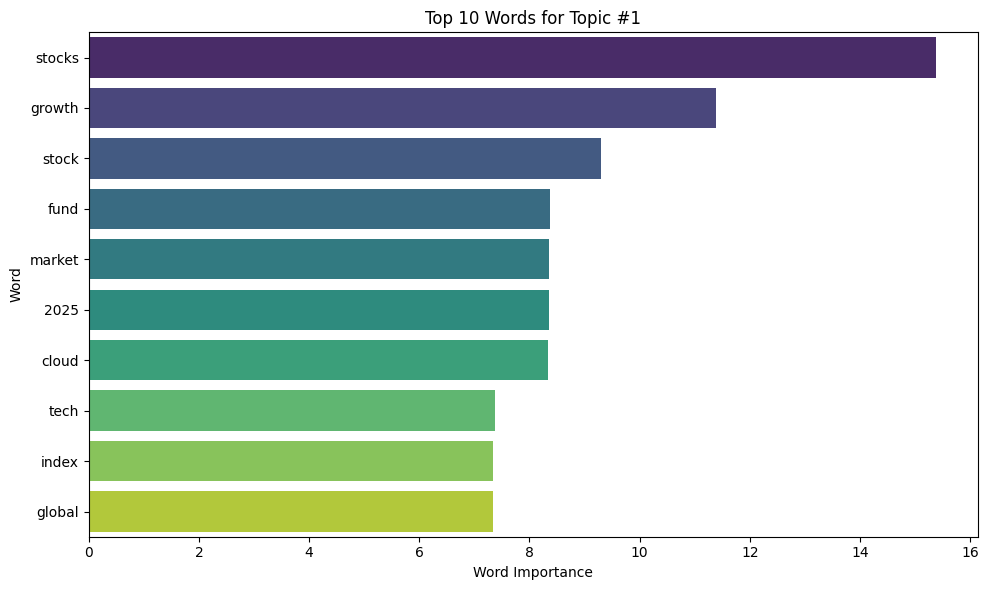

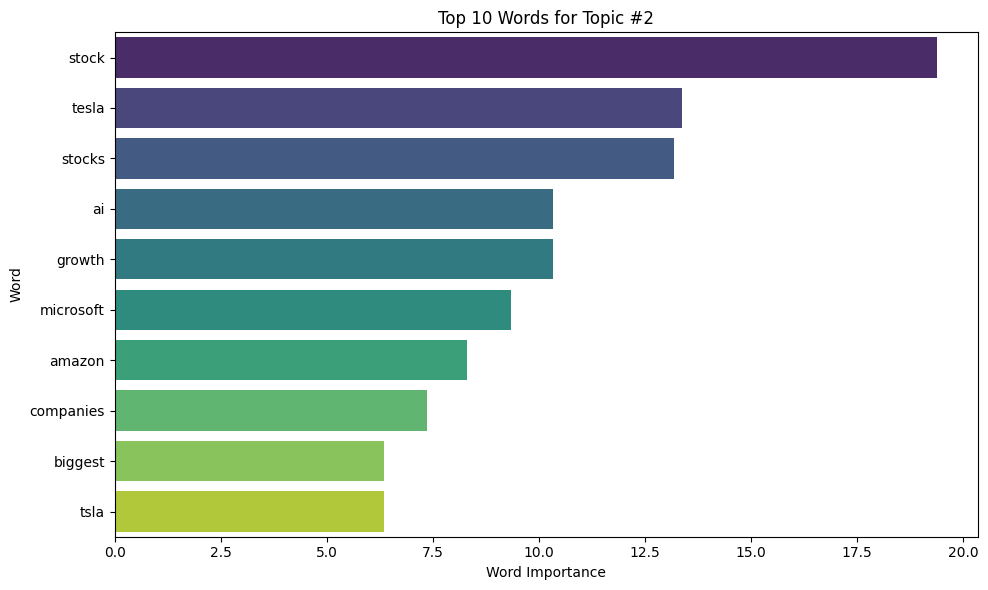

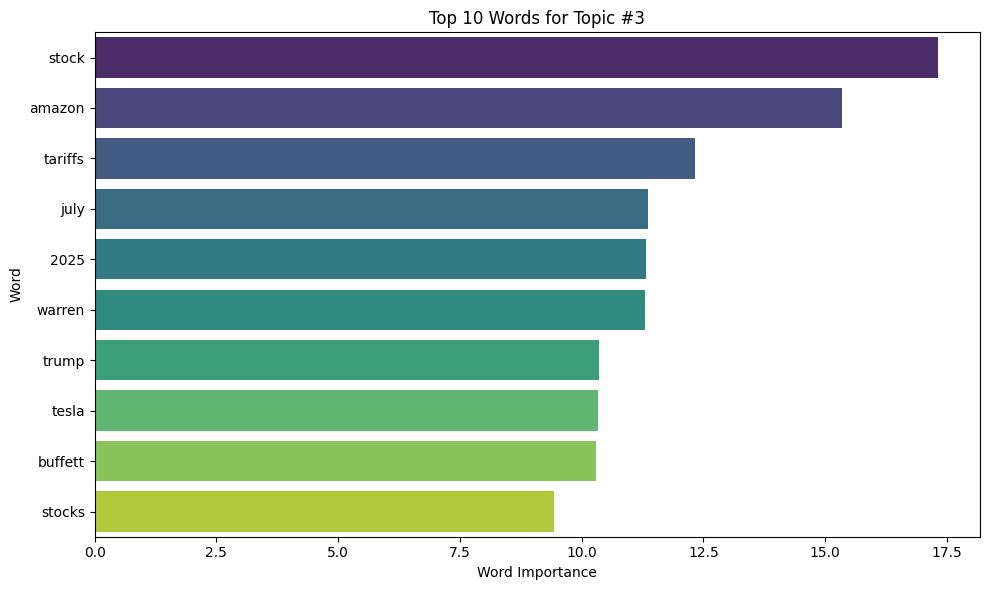

In [15]:
def plot_topic_words_bar(model, feature_names, topic_idx=0, n_top_words=10):
	topic = model.components_[topic_idx]
	# Ensure indices are within bounds of feature_names
	top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
	top_features_ind = [i for i in top_features_ind if i < len(feature_names)]
	top_features = [feature_names[i] for i in top_features_ind]
	top_weights = topic[top_features_ind]

	plt.figure(figsize=(10, 6))
	sns.barplot(x=top_weights, y=top_features, palette="viridis")
	plt.title(f"Top {n_top_words} Words for Topic #{topic_idx + 1}")
	plt.xlabel("Word Importance")
	plt.ylabel("Word")
	plt.tight_layout()
	plt.show()

# Example usage for LDA topics
for i in range(min(3, best_lda.components_.shape[0])):
	plot_topic_words_bar(best_lda, feature_names, topic_idx=i)


Visualising Word Clouds of topics

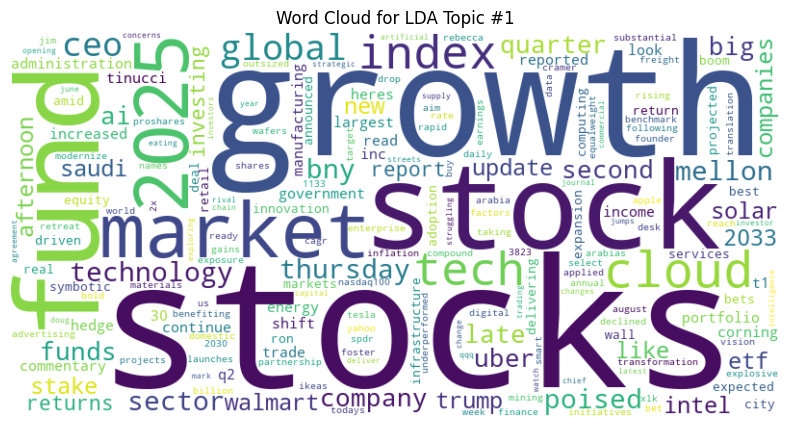

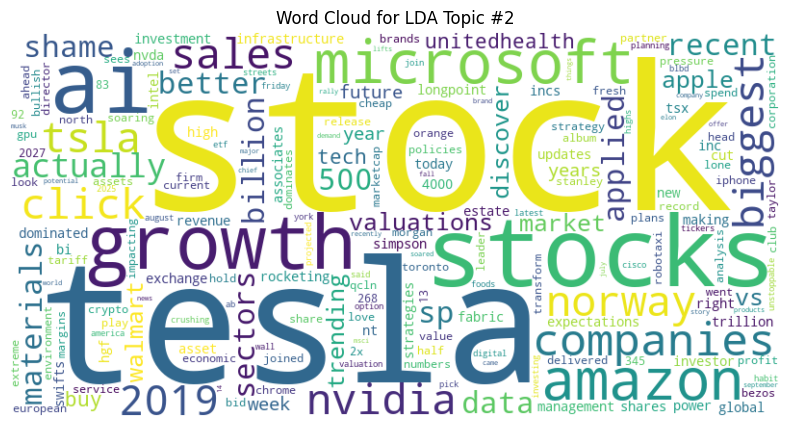

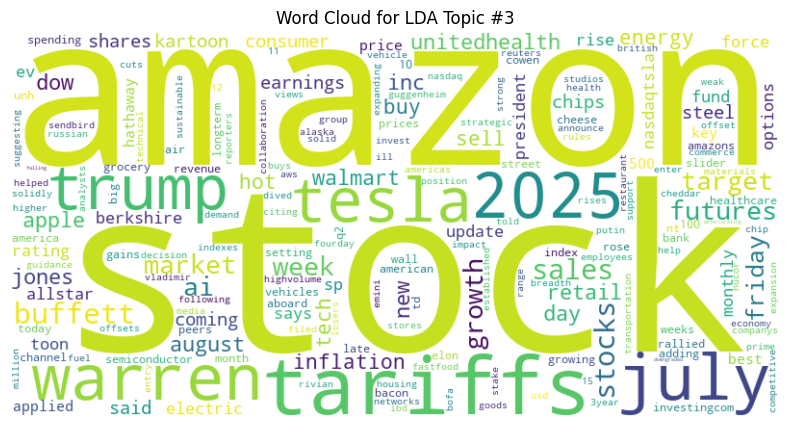

In [19]:
from wordcloud import WordCloud


num_topics = best_lda.components_.shape[0]
feature_names = feature_names

for topic_idx, topic in enumerate(best_lda.components_):
    # Get top words and their weights for the topic
    word_weights = {feature_names[i]: topic[i] for i in range(len(feature_names))}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for LDA Topic #{topic_idx + 1}')
    plt.show()

Evaluation of metrics -Perplexity and coherence score

In [ ]:


perplexity = best_lda.perplexity(bow_matrix)
print(f"LDA Perplexity: {perplexity:.2f}")


texts = [doc.split() for doc in documents]
corpus = [vectorizer.transform([' '.join(text)]).toarray()[0] for text in texts]
dictionary = Dictionary(texts)


gensim_corpus = [dictionary.doc2bow(text) for text in texts]


sklearn_topics = []
for topic_idx, topic in enumerate(best_lda.components_):
    top_features_ind = topic.argsort()[:-10 - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    sklearn_topics.append(top_features)

# Coherence Score (c_v)
coherence_model = CoherenceModel(topics=sklearn_topics, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"LDA Coherence Score (c_v): {coherence_score:.3f}")

LDA Perplexity: 1309.90
LDA Coherence Score (c_v): 0.334


# Topic Modeling with Non-negative Matrix Factorization (NMF)

Hyperparameter tuning for NMF using three parameters (number of topics, alpha_W(regularization strength), and l1_ratio(regularization mixing)). The input features are generated using TF-IDF vectorization.

In [38]:

tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Hyperparameter grids
n_topics_list = [3, 5, 7, 10]
alpha_list = [0.0, 0.1, 0.5]
l1_ratio_list = [0.0, 0.5, 1.0]

best_coherence = -1
best_params = None
best_nmf_tfidf_model = None

texts = [doc.split() for doc in documents]
dictionary = Dictionary(texts)

for n_topics in n_topics_list:
    for alpha in alpha_list:
        for l1_ratio in l1_ratio_list:
            nmf_model = NMF(n_components=n_topics, alpha_W=alpha, l1_ratio=l1_ratio, random_state=42)
            nmf_topics = nmf_model.fit_transform(tfidf_matrix)
            # Extract topics
            nmf_topics_words = []
            for topic in nmf_model.components_:
                top_features_ind = topic.argsort()[:-10 - 1:-1]
                top_features = [tfidf_feature_names[i] for i in top_features_ind]
                nmf_topics_words.append(top_features)
            coherence_model_nmf = CoherenceModel(topics=nmf_topics_words, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_score_nmf = coherence_model_nmf.get_coherence()
            reconstruction_err = nmf_model.reconstruction_err_
            print(f'n_topics={n_topics}, alpha_W={alpha}, l1_ratio={l1_ratio}, Reconstruction Error={reconstruction_err:.2f}, Coherence={coherence_score_nmf:.3f}')
            if coherence_score_nmf > best_coherence:
                best_coherence = coherence_score_nmf
                best_params = (n_topics, alpha, l1_ratio)
                best_nmf_tfidf_model = nmf_model

print(f'\nBest NMF (TFIDF): n_topics={best_params[0]}, alpha={best_params[1]}, l1_ratio={best_params[2]}, Coherence={best_coherence:.3f}')
print("\nTop words for each topic in the best NMF (TFIDF) model:")
def print_top_words_nmf_tfidf(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Topic #{topic_idx + 1}:")
        print("  ", " ".join(top_features))
        print()
print_top_words_nmf_tfidf(best_nmf_tfidf_model, tfidf_feature_names)

n_topics=3, alpha_W=0.0, l1_ratio=0.0, Reconstruction Error=9.45, Coherence=0.654
n_topics=3, alpha_W=0.0, l1_ratio=0.5, Reconstruction Error=9.45, Coherence=0.654
n_topics=3, alpha_W=0.0, l1_ratio=0.5, Reconstruction Error=9.45, Coherence=0.654
n_topics=3, alpha_W=0.0, l1_ratio=1.0, Reconstruction Error=9.45, Coherence=0.654
n_topics=3, alpha_W=0.0, l1_ratio=1.0, Reconstruction Error=9.45, Coherence=0.654
n_topics=3, alpha_W=0.1, l1_ratio=0.0, Reconstruction Error=10.00, Coherence=0.391
n_topics=3, alpha_W=0.1, l1_ratio=0.0, Reconstruction Error=10.00, Coherence=0.391
n_topics=3, alpha_W=0.1, l1_ratio=0.5, Reconstruction Error=10.00, Coherence=0.678
n_topics=3, alpha_W=0.1, l1_ratio=0.5, Reconstruction Error=10.00, Coherence=0.678
n_topics=3, alpha_W=0.1, l1_ratio=1.0, Reconstruction Error=10.00, Coherence=0.659
n_topics=3, alpha_W=0.1, l1_ratio=1.0, Reconstruction Error=10.00, Coherence=0.659
n_topics=3, alpha_W=0.5, l1_ratio=0.0, Reconstruction Error=10.00, Coherence=0.518
n_topics=

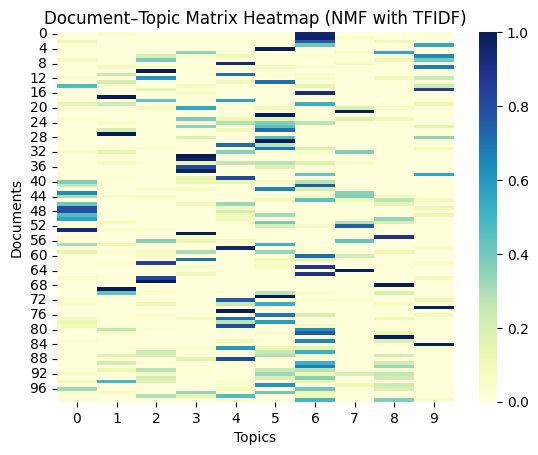

In [42]:

W = best_nmf_tfidf_model.transform(tfidf_matrix)
W_normalized = W / W.sum(axis=1, keepdims=True)  # row-wise normalization

sns.heatmap(W_normalized,cmap='YlGnBu')
plt.title("Document–Topic Matrix Heatmap (NMF with TFIDF)")
plt.xlabel("Topics")
plt.ylabel("Documents")
plt.show()

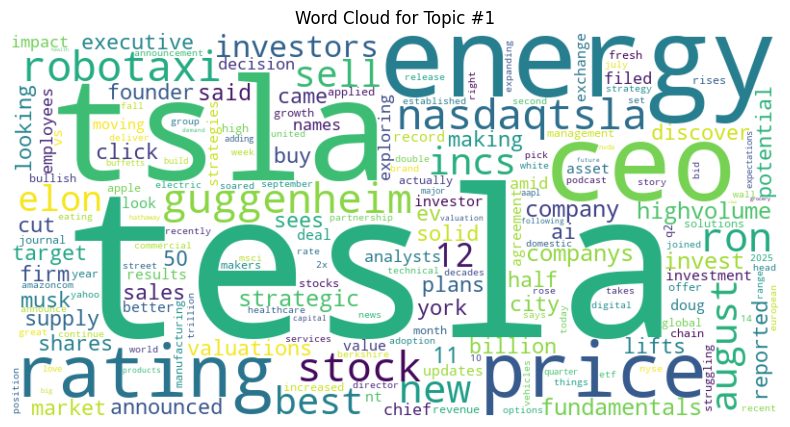

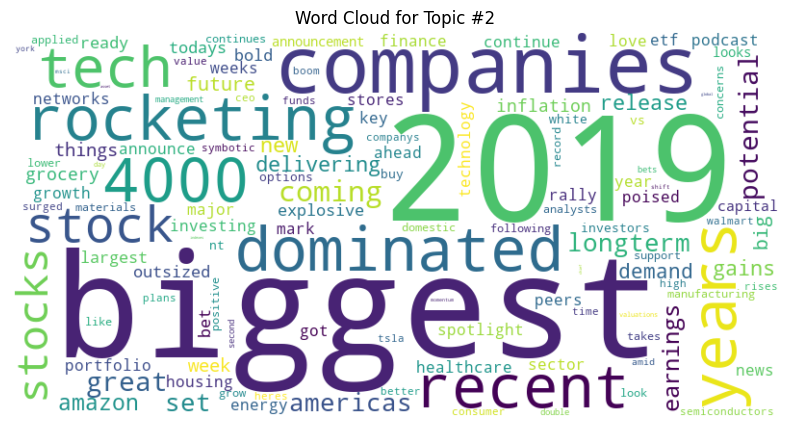

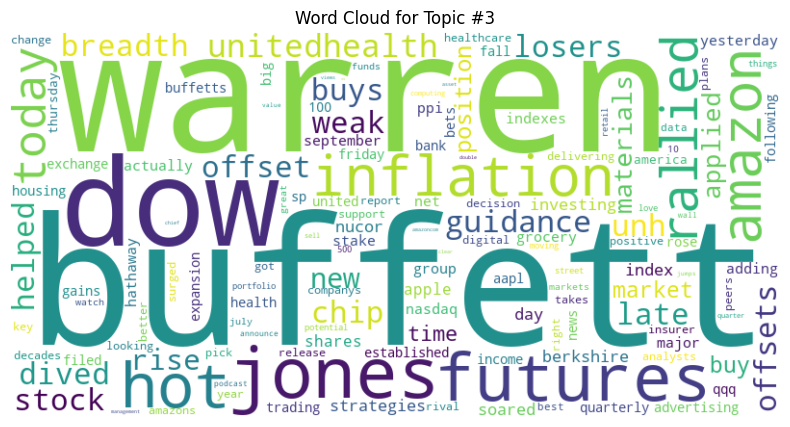

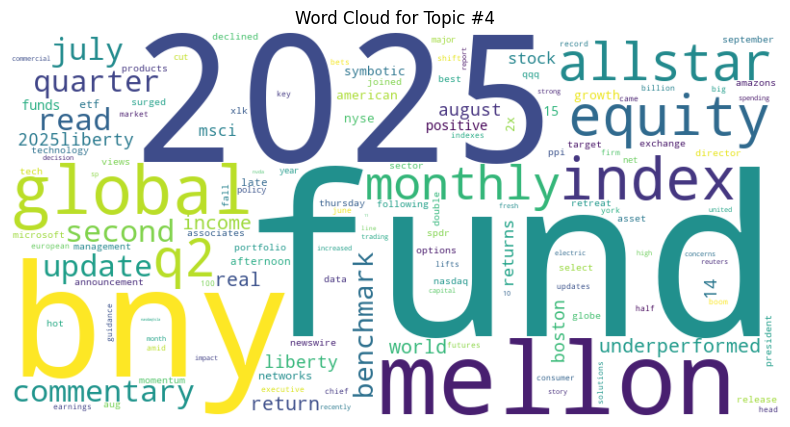

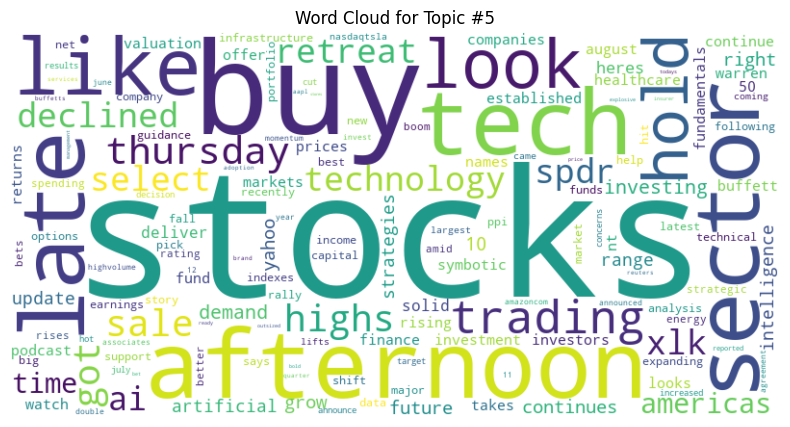

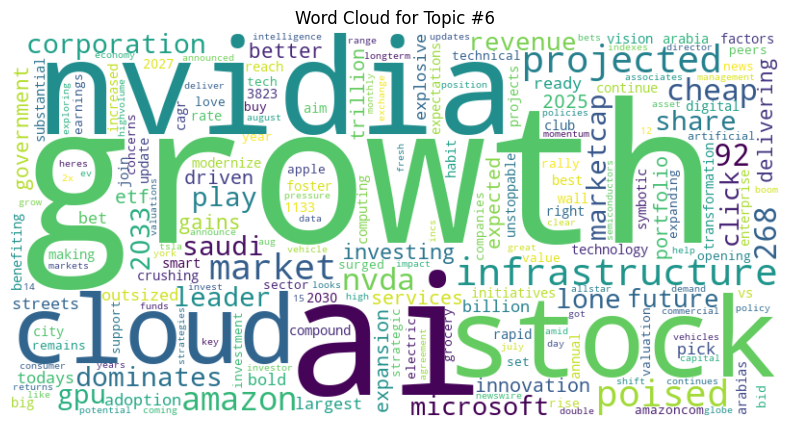

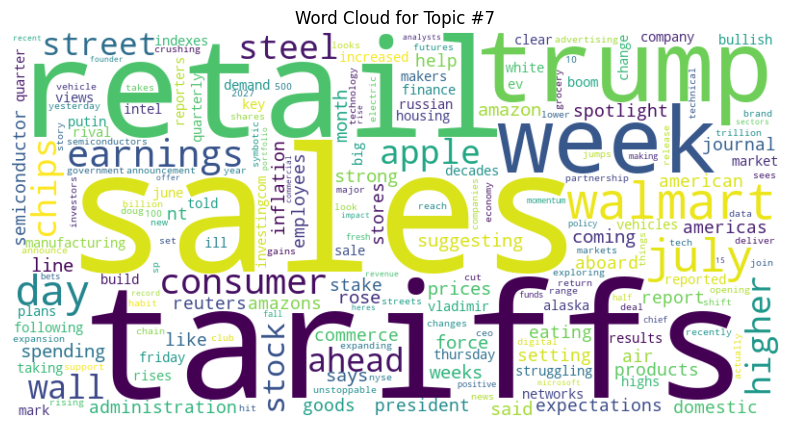

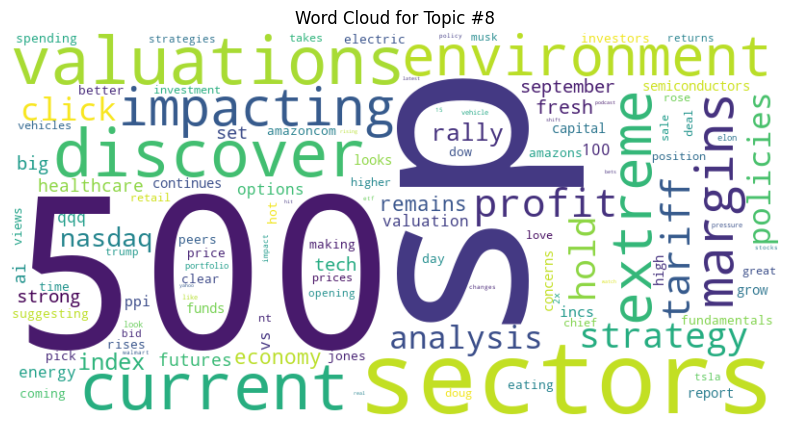

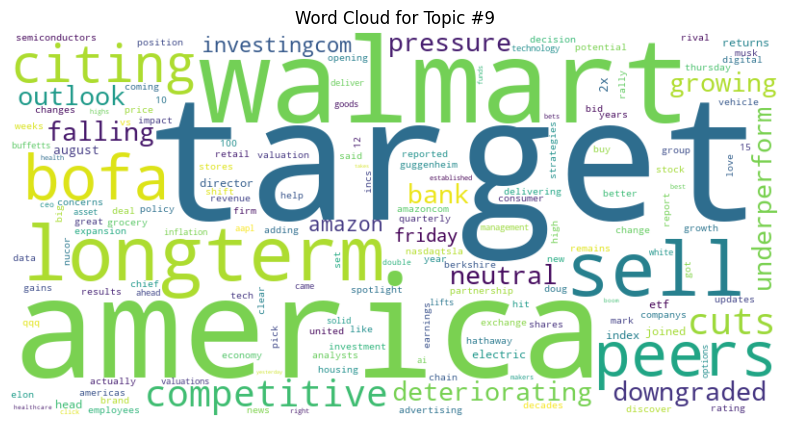

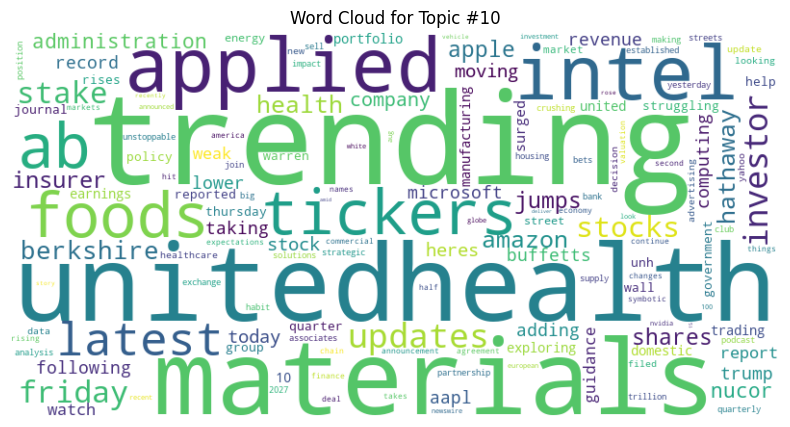

In [ ]:

num_topics = best_nmf_tfidf_model.components_.shape[0]
feature_names = tfidf_feature_names

for topic_idx, topic in enumerate(best_nmf_tfidf_model.components_):
    # Get top words and their weights
    word_weights = {feature_names[i]: topic[i] for i in range(len(feature_names))}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Topic #{topic_idx + 1}')
    plt.show()